# PCA-Reduced Logistic Regression for Text Classification

**Author:** Oluwafemi Lawal (Olawal7308@conestogac.on.ca)  
**Student ID:** 8967308  
**Course:** PROG8245 - Machine Learning Programming  
**Project:** Text Classification with Dimensionality Reduction (Group 4)

---

## Overview

This notebook implements **Steps 6 & 7** of the project:
- **Step 6:** Dimensionality Reduction with PCA
- **Step 7:** Model Training - Logistic Regression with PCA

### What is PCA?

**Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms data into a new coordinate system where:
- The first principal component captures the maximum variance
- Each subsequent component captures the maximum remaining variance while being orthogonal to previous components

### Key Differences from SVD:
- **PCA requires standardization** (centering and scaling) of data
- PCA works on the covariance matrix of the data
- SVD can work directly on sparse matrices, while PCA typically requires dense matrices

---

## Step 1: Import Libraries and Setup Path

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Train-test split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Path setup
import os
import sys

# --- PATH SETUP ---
curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import custom modules
from Data_Processing.EDA import DataProcessor
from Models.PCA_Reduced_Model import PCAReducedModel
from Visualization.Visualizer import Visualizer

print("All libraries imported successfully!")
print(f"Working directory: {curr_dir}")
print(f"Parent directory added to path: {parent_dir}")

All libraries imported successfully!
Working directory: c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\PROG8245_Final_Project\Notebooks
Parent directory added to path: c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\PROG8245_Final_Project


## Step 2: Load and Explore the Data

We'll use the SMS Spam Collection dataset which contains labeled SMS messages (ham/spam).

In [2]:
# Load data using the DataProcessor class
data_processor = DataProcessor(data_path="../data/raw/SMSSpamCollection")
data_processor.load_data(sep="\t", header=None, names=['label', 'message'])

# Get the dataframe
df = data_processor.data

# Display basic info
print(f"Dataset Shape: {df.shape}")
print(f"\nClass Distribution:")
print(df['label'].value_counts())
print(f"\nClass Distribution (%):")
print(df['label'].value_counts(normalize=True) * 100)

# Display sample data
df.head(10)

Data loaded successfully.
Dataset Shape: (5572, 2)

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class Distribution (%):
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


## Step 3: Split Data into Training and Testing Sets

Following the project requirements: **75% training, 25% testing**

In [3]:
# Split features and labels
X = df['message']
y = df['label']

# Split: 75% train, 25% test (as per project requirements)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,  # 25% for testing
    random_state=42,  # For reproducibility
    stratify=y  # Maintain class distribution
)

print(f"Training set size: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: 4179 samples (75.0%)
Testing set size: 1393 samples (25.0%)

Training set class distribution:
label
ham     3619
spam     560
Name: count, dtype: int64

Testing set class distribution:
label
ham     1206
spam     187
Name: count, dtype: int64


## Step 4: TF-IDF Feature Extraction

Before applying PCA, we first need to convert text to TF-IDF features.

In [4]:
# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    stop_words='english',  # Remove common English stopwords
    lowercase=True,  # Convert to lowercase
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit on training data and transform both sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Feature Matrix Shape (Training): {X_train_tfidf.shape}")
print(f"TF-IDF Feature Matrix Shape (Testing): {X_test_tfidf.shape}")
print(f"\nVocabulary size: {len(tfidf_vectorizer.vocabulary_)} terms")
print(f"Matrix sparsity: {1 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.4f}")

# Store original dimensions for later comparison
original_features = X_train_tfidf.shape[1]
print(f"\n✓ Original TF-IDF features: {original_features}")

TF-IDF Feature Matrix Shape (Training): (4179, 5000)
TF-IDF Feature Matrix Shape (Testing): (1393, 5000)

Vocabulary size: 5000 terms
Matrix sparsity: 0.9983

✓ Original TF-IDF features: 5000


---

## Step 6: Dimensionality Reduction with PCA

### Why PCA for Text Data?

PCA (Principal Component Analysis) transforms the high-dimensional TF-IDF feature space into a lower-dimensional space by:

1. **Finding Principal Components:** Directions of maximum variance in the data
2. **Projecting Data:** Transforming data onto these new axes
3. **Reducing Dimensions:** Keeping only the top components that capture most variance

### Important Considerations for PCA on Text Data:

- **Standardization Required:** Unlike SVD, PCA requires data to be centered (zero mean). For sparse TF-IDF matrices, we use `StandardScaler(with_mean=False)` to avoid destroying sparsity.
- **Dense Matrix Required:** PCA cannot work with sparse matrices, so we must convert to dense arrays (more memory intensive than SVD).
- **Comparison with SVD:** SVD (Truncated SVD / LSA) can work directly on sparse matrices and doesn't require centering, making it more efficient for text data.

In [5]:
# Number of PCA components (same as SVD for fair comparison)
N_COMPONENTS = 100

# Initialize the PCA-Reduced Model
pca_model = PCAReducedModel(n_components=N_COMPONENTS, random_state=42)

# Apply PCA transformation
X_train_pca, X_test_pca = pca_model.fit_transform_pca(X_train_tfidf, X_test_tfidf)

print(f"\n✓ Dimensionality reduced from {original_features} to {X_train_pca.shape[1]} features")
print(f"✓ Reduction ratio: {(1 - X_train_pca.shape[1]/original_features)*100:.1f}%")

Standardizing TF-IDF features...
Applying PCA with 100 components...
Applying PCA with 100 components...
Original shape: (4179, 5000)
PCA-reduced shape: (4179, 100)
Total explained variance ratio: 0.2997

✓ Dimensionality reduced from 5000 to 100 features
✓ Reduction ratio: 98.0%
Original shape: (4179, 5000)
PCA-reduced shape: (4179, 100)
Total explained variance ratio: 0.2997

✓ Dimensionality reduced from 5000 to 100 features
✓ Reduction ratio: 98.0%


### Visualize the Explained Variance Ratio

Let's examine how much variance is captured by each principal component and cumulatively.

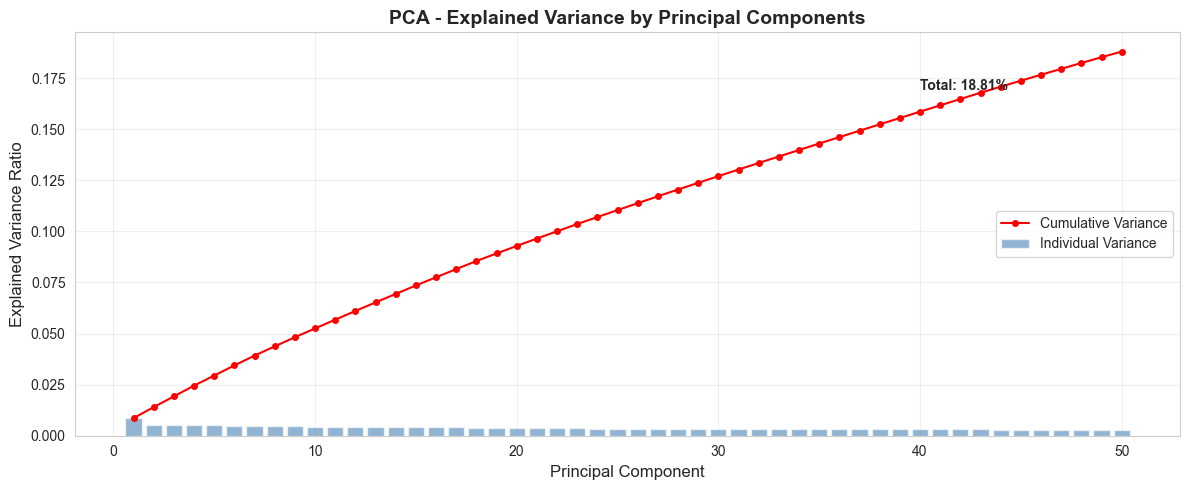


Variance Statistics:
  - Total variance explained by 100 components: 0.2997 (29.97%)
  - Variance explained by first 10 components: 0.0525 (5.25%)
  - Variance explained by first 50 components: 0.1881 (18.81%)


In [6]:
# Get explained variance
individual_var, cumulative_var = pca_model.get_explained_variance()

# Initialize visualizer
visualizer = Visualizer(figsize=(10, 6))

# Plot variance explained
fig, ax = plt.subplots(figsize=(12, 5))
visualizer.plot_variance_explained(
    individual_var, 
    title='PCA - Explained Variance by Principal Components',
    n_components_to_show=50,
    ax=ax
)
plt.tight_layout()
plt.show()

# Print variance statistics
print(f"\nVariance Statistics:")
print(f"  - Total variance explained by {N_COMPONENTS} components: {cumulative_var[-1]:.4f} ({cumulative_var[-1]*100:.2f}%)")
print(f"  - Variance explained by first 10 components: {cumulative_var[9]:.4f} ({cumulative_var[9]*100:.2f}%)")
print(f"  - Variance explained by first 50 components: {cumulative_var[49]:.4f} ({cumulative_var[49]*100:.2f}%)")

### Analysis: How PCA Captures Semantic Relationships

**What the variance plot tells us:**

1. **First few components are most important:** The first principal components capture the most variance, representing the most significant patterns in the text data.

2. **Diminishing returns:** Each additional component captures less variance, showing that much of the information in high-dimensional TF-IDF space is redundant.

3. **Text data characteristics:** Unlike image data where PCA typically captures 90%+ variance with fewer components, text data often requires more components to capture the same variance due to its high sparsity and complex semantic relationships.

**For our text classification task:**
- PCA finds linear combinations of TF-IDF features that maximize variance
- These combinations may (but don't always) correspond to semantic concepts
- Unlike SVD/LSA, PCA doesn't specifically target latent semantic relationships

---

## Step 7: Model Training - Logistic Regression with PCA

Now we'll train a Logistic Regression classifier on the PCA-reduced features and evaluate its performance.

In [7]:
# Train Logistic Regression on PCA-reduced features
pca_model.train(X_train_pca, y_train)

# Make predictions
y_pred_pca = pca_model.predict(X_test_pca)

print("✓ Model trained and predictions made!")

Training Logistic Regression on PCA-reduced features...
Training complete!
✓ Model trained and predictions made!


### Confusion Matrix Visualization

The confusion matrix shows us exactly where our model is making correct predictions and where it's making errors.

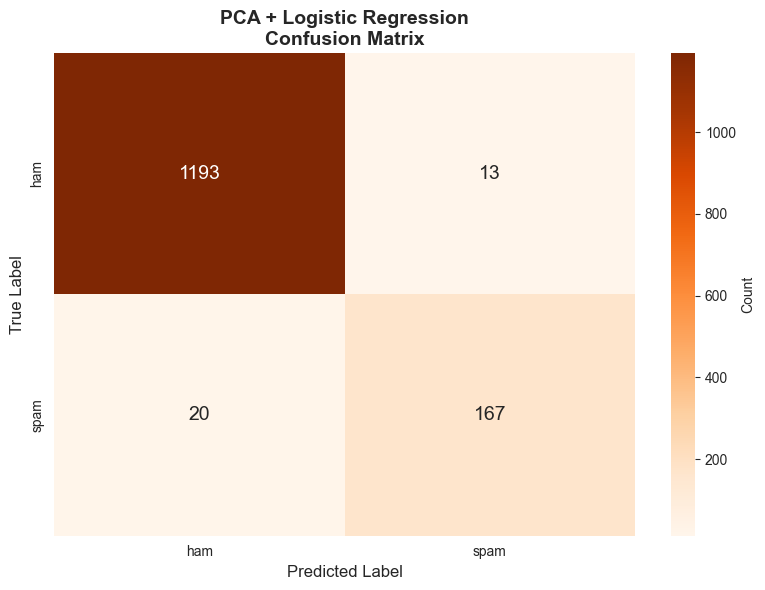


CONFUSION MATRIX BREAKDOWN

True Negatives (Ham correctly classified):  1193
True Positives (Spam correctly classified): 167
False Positives (Ham misclassified as Spam): 13
False Negatives (Spam misclassified as Ham): 20

Total Correct: 1360 / 1393
Total Incorrect: 33 / 1393


In [8]:
# Define class labels
labels = ['ham', 'spam']

# Create confusion matrix visualization
fig, ax = plt.subplots(figsize=(8, 6))
visualizer.plot_confusion_matrix(
    y_test, y_pred_pca,
    labels=labels,
    title='PCA + Logistic Regression\nConfusion Matrix',
    cmap='Oranges',
    ax=ax
)
plt.tight_layout()
plt.show()

# Get detailed confusion matrix breakdown
cm_details = pca_model.get_confusion_matrix_details(y_test, y_pred_pca, labels=labels)

print("\n" + "="*50)
print("CONFUSION MATRIX BREAKDOWN")
print("="*50)
print(f"\nTrue Negatives (Ham correctly classified):  {cm_details['true_negatives']}")
print(f"True Positives (Spam correctly classified): {cm_details['true_positives']}")
print(f"False Positives (Ham misclassified as Spam): {cm_details['false_positives']}")
print(f"False Negatives (Spam misclassified as Ham): {cm_details['false_negatives']}")
print(f"\nTotal Correct: {cm_details['total_correct']} / {cm_details['total_samples']}")
print(f"Total Incorrect: {cm_details['total_incorrect']} / {cm_details['total_samples']}")

### Model Performance Metrics

Let's calculate and display all the key performance metrics.

In [9]:
# Print comprehensive evaluation summary
pca_model.print_evaluation_summary(y_test)

# Store metrics for comparison
pca_metrics = pca_model.metrics


PCA-REDUCED LOGISTIC REGRESSION MODEL EVALUATION

Model Configuration:
  - PCA Components: 100
  - Explained Variance: 0.2997

Performance Metrics:
  - Accuracy:  0.9763
  - Precision: 0.9278
  - Recall:    0.8930
  - F1-Score:  0.9101

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1206
        spam       0.93      0.89      0.91       187

    accuracy                           0.98      1393
   macro avg       0.96      0.94      0.95      1393
weighted avg       0.98      0.98      0.98      1393



---

## Analysis: Interpretation of Results

### Confusion Matrix Interpretation

**For the PCA + Logistic Regression model:**

1. **True Negatives (TN):** Ham messages correctly identified as ham
   - High TN indicates the model is good at recognizing legitimate messages
   
2. **True Positives (TP):** Spam messages correctly identified as spam
   - High TP indicates the model effectively catches spam

3. **False Positives (FP):** Ham messages incorrectly classified as spam
   - These are problematic as legitimate messages may be filtered out
   - In spam detection, we want to minimize FPs to avoid missing important messages

4. **False Negatives (FN):** Spam messages incorrectly classified as ham
   - These are spam messages that slip through the filter
   - While annoying, usually less critical than FPs in most use cases

### Impact of Dimensionality Reduction

**How does reducing dimensions affect model accuracy and speed?**

1. **Accuracy Impact:**
   - Reducing from thousands of TF-IDF features to ~100 PCA components may cause some information loss
   - However, PCA keeps the most variant (and often most informative) directions
   - Performance depends on how well variance correlates with class separation

2. **Speed Impact:**
   - Training is MUCH faster with 100 features vs 5000+ features
   - Prediction is also faster
   - Memory usage is significantly reduced (dense 100-dim vectors vs sparse 5000-dim vectors)

3. **Trade-offs:**
   - PCA requires converting sparse TF-IDF to dense matrices (memory cost)
   - PCA requires standardization (additional preprocessing step)
   - The reduced features lose interpretability (can't examine specific words anymore)

---

## Save Results for Model Comparison

We'll save the predictions and metrics so they can be used in the final comparison notebook.

In [10]:
# Create results dictionary for later comparison
pca_results = {
    'model_name': 'PCA + Logistic Regression',
    'n_components': N_COMPONENTS,
    'original_features': original_features,
    'reduced_features': X_train_pca.shape[1],
    'explained_variance': pca_model.pca.explained_variance_ratio_.sum(),
    'y_true': y_test,
    'y_pred': y_pred_pca,
    'metrics': {
        'accuracy': pca_metrics['accuracy'],
        'precision': pca_metrics['precision'],
        'recall': pca_metrics['recall'],
        'f1_score': pca_metrics['f1_score']
    }
}

# Save to pickle for use in comparison notebook
import pickle
results_path = '../data/pca_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(pca_results, f)
    
print(f"✓ Results saved to: {results_path}")
print(f"\nSummary of saved results:")
print(f"  - Model: {pca_results['model_name']}")
print(f"  - Components: {pca_results['n_components']}")
print(f"  - Explained Variance: {pca_results['explained_variance']:.4f}")
print(f"  - Accuracy: {pca_results['metrics']['accuracy']:.4f}")

✓ Results saved to: ../data/pca_results.pkl

Summary of saved results:
  - Model: PCA + Logistic Regression
  - Components: 100
  - Explained Variance: 0.2997
  - Accuracy: 0.9763


---

## Summary

In this notebook, we implemented:

1. **Step 6: PCA Dimensionality Reduction**
   - Standardized TF-IDF features (required for PCA)
   - Applied PCA to reduce dimensions from ~5000 to 100
   - Visualized and analyzed explained variance

2. **Step 7: Logistic Regression with PCA Features**
   - Trained Logistic Regression on PCA-reduced features
   - Generated confusion matrix with detailed analysis
   - Calculated accuracy, precision, recall, and F1-score

### Key Observations:

- PCA effectively reduces dimensionality while preserving variance
- The model performance on PCA-reduced features provides a comparison point for SVD
- Dimensionality reduction significantly speeds up training while potentially trading off some accuracy

### Next Steps:

The results from this notebook will be combined with:
- Model 1: Naive Bayes with TF-IDF (Mostafa's work)
- Model 2: Logistic Regression with SVD (Jarius's work)

For the final comparison in the **Model_Comparison.ipynb** notebook.